In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import plotly.offline as pyoff
import plotly.graph_objs as go

import datetime as dt
import feature_engine

from feature_engine.outliers import Winsorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Dataset
df = pd.read_csv('C:/Users/USER/Downloads/data_rfm_b2c.csv')

In [3]:
df = df.dropna(subset = ["total_price", "delivered_at_wib"])
df["created_at"] = pd.to_datetime(df['created_at'])
#df['client_code'] = df['client_code'].astype("string")
df = df[df.region == 'Jakarta']
df['total_price']=df['total_price'].astype(int)
df = df[df["total_price"] > 0]

In [4]:
df.head()

order_id   client_code  total_price          created_at  \
0   1643424  2.012031e+14      2400000 2022-03-15 13:18:42   
1   1643424  2.012031e+14     11592000 2022-03-15 13:18:42   
2   1643424  2.012031e+14      4968000 2022-03-15 13:18:42   
3   1643575  2.203100e+14      2878870 2022-03-15 15:26:56   
4   1643575  2.203100e+14     15229875 2022-03-15 15:26:56   

           paid_at_wib     delivered_at_wib   region  client_type_id  
0  2022-03-21 09:49:25  2022-03-16 14:43:00  Jakarta              13  
1  2022-03-21 09:49:25  2022-03-16 14:43:00  Jakarta              13  
2  2022-03-21 09:49:25  2022-03-16 14:43:00  Jakarta              13  
3  2022-03-17 12:48:57  2022-03-16 12:58:00  Jakarta              13  
4  2022-03-17 12:48:57  2022-03-16 12:58:00  Jakarta              13

In [5]:
df.tail()

order_id   client_code  total_price          created_at  \
846934    583576  1.902180e+14         9000 2021-01-07 10:56:22   
846935    583576  1.902180e+14        16500 2021-01-07 10:56:22   
846936    583576  1.902180e+14        10000 2021-01-07 10:56:22   
846937    583576  1.902180e+14         8000 2021-01-07 10:56:22   
846938    583576  1.902180e+14       221000 2021-01-07 10:56:22   

                paid_at_wib     delivered_at_wib   region  client_type_id  
846934  2021-01-07 10:56:58  2021-01-07 07:00:00  Jakarta              11  
846935  2021-01-07 10:56:58  2021-01-07 07:00:00  Jakarta              11  
846936  2021-01-07 10:56:58  2021-01-07 07:00:00  Jakarta              11  
846937  2021-01-07 10:56:58  2021-01-07 07:00:00  Jakarta              11  
846938  2021-01-07 10:56:58  2021-01-07 07:00:00  Jakarta              11

In [6]:
df.shape

(538953, 8)

# Data Preparation 

In [7]:
def summary(df, pred=None):
  obs = df.shape[0]
  types = df.dtypes
  counts = df.apply(lambda x: x.count())
  min = df.min()
  uniques = df.apply(lambda x: x.unique().shape[0])
  nulls = df.apply(lambda x: x.isnull().sum())
  print('Data shape:', df.shape)

  if pred is None:
        cols = ['types', 'counts', 'uniques', 'nulls', 'min']
        str = pd.concat([types, counts, uniques, nulls, min], axis = 1, sort=True)

  str.columns = cols
  dtypes = str.types.value_counts()
  print('___________________________\nData types:')
  print(str.types.value_counts())
  print('___________________________')
  return str

details = summary(df)
display(details.sort_values(by='nulls', ascending=False))

Data shape: (538953, 8)
___________________________
Data types:
object            3
int64             2
float64           1
datetime64[ns]    1
int32             1
Name: types, dtype: int64
___________________________


types  counts  uniques   nulls                  min
paid_at_wib               object  273542    25068  265411                  NaN
client_code              float64  538947     3661       6    180521073447031.0
client_type_id             int64  538953        9       0                    3
created_at        datetime64[ns]  538953   173426       0  2021-01-01 06:03:45
delivered_at_wib          object  538953    21726       0  2021-01-02 00:00:00
order_id                   int64  538953   243120       0               419491
region                    object  538953        1       0              Jakarta
total_price                int32  538953    23795       0                    1

In [8]:
df.describe().T

count          mean           std           min  \
order_id        538953.0  1.112808e+06  4.007509e+05  4.194910e+05   
client_code     538947.0  2.052388e+14  8.240696e+12  1.805211e+14   
total_price     538953.0  7.527148e+05  1.291427e+07  1.000000e+00   
client_type_id  538953.0  1.016947e+01  2.436461e+00  3.000000e+00   

                         25%           50%           75%           max  
order_id        7.187240e+05  1.188149e+06  1.483143e+06  1.794148e+06  
client_code     2.012100e+14  2.101051e+14  2.102220e+14  2.204030e+14  
total_price     2.025000e+04  5.100000e+04  2.004000e+05  2.142000e+09  
client_type_id  8.000000e+00  1.000000e+01  1.300000e+01  1.500000e+01

In [9]:
df.client_type_id.unique()

array([13, 10, 11, 12,  3,  8, 14, 15,  9], dtype=int64)

In [10]:
df.isnull().mean()*100

order_id             0.000000
client_code          0.001113
total_price          0.000000
created_at           0.000000
paid_at_wib         49.245667
delivered_at_wib     0.000000
region               0.000000
client_type_id       0.000000
dtype: float64

In [11]:
#Removing the Null values from the data.
df = df[pd.notnull(df['client_code'])]

In [12]:
print(f'Max transaction date: {df["created_at"].max()}')
print(f'Min transaction date: {df["created_at"].min()}')

Max transaction date: 2022-04-03 21:22:07
Min transaction date: 2021-01-01 06:03:45


In [13]:
NOW = dt.date(2022,4,3) 
df['Date'] = pd.DatetimeIndex(df.created_at).date

# Recency

In [14]:
df_recency = df.groupby(['client_code'],as_index=False)['Date'].max()
df_recency.columns = ['client_code','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

client_code  Recency
0  1.805211e+14        1
1  1.805211e+14      416
2  1.805220e+14        0
3  1.805221e+14       99
4  1.805241e+14      167

Frequency - Monetarty

In [15]:
FM_Table = df.groupby('client_code').agg({'created_at'   : lambda x:len(x),
                                         'total_price'  : lambda x:x.sum()})
FM_Table.rename(columns = {'created_at' :'Frequency',
                           'total_price':'Monetary'},inplace= True)
FM_Table.head()

Frequency    Monetary
client_code                        
1.805211e+14       1829  2597177575
1.805211e+14         12    11152500
1.805220e+14      12518  5002966483
1.805221e+14        248  1026178550
1.805241e+14         61   114642100

In [16]:
RFM_Table = df_recency.merge(FM_Table,left_on='client_code',right_on='client_code')
RFM_Table.head()

client_code  Recency  Frequency    Monetary
0  1.805211e+14        1       1829  2597177575
1  1.805211e+14      416         12    11152500
2  1.805220e+14        0      12518  5002966483
3  1.805221e+14       99        248  1026178550
4  1.805241e+14      167         61   114642100

In [17]:
quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [18]:
segmented_rfm = RFM_Table.copy()

In [19]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [20]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

client_code  Recency  Frequency    Monetary  R_quartile  F_quartile  \
0  1.805211e+14        1       1829  2597177575           1           1   
1  1.805211e+14      416         12    11152500           4           2   
2  1.805220e+14        0      12518  5002966483           1           1   
3  1.805221e+14       99        248  1026178550           3           1   
4  1.805241e+14      167         61   114642100           4           1   

   M_quartile  
0           1  
1           2  
2           1  
3           1  
4           1

In [21]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)

In [22]:
segmented_rfm.head()

client_code  Recency  Frequency    Monetary  R_quartile  F_quartile  \
0  1.805211e+14        1       1829  2597177575           1           1   
1  1.805211e+14      416         12    11152500           4           2   
2  1.805220e+14        0      12518  5002966483           1           1   
3  1.805221e+14       99        248  1026178550           3           1   
4  1.805241e+14      167         61   114642100           4           1   

   M_quartile RFM_Segment  
0           1         111  
1           2         422  
2           1         111  
3           1         311  
4           1         411

In [23]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

In [24]:
segmented_rfm.head()

client_code  Recency  Frequency    Monetary  R_quartile  F_quartile  \
0  1.805211e+14        1       1829  2597177575           1           1   
1  1.805211e+14      416         12    11152500           4           2   
2  1.805220e+14        0      12518  5002966483           1           1   
3  1.805221e+14       99        248  1026178550           3           1   
4  1.805241e+14      167         61   114642100           4           1   

   M_quartile RFM_Segment  RFM_Score  
0           1         111          3  
1           2         422          8  
2           1         111          3  
3           1         311          5  
4           1         411          6

In [25]:
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Almost Lost: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Lost Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Customers:  228
Loyal Customers:  903
Big Spenders:  915
Almost Lost:  40
Lost Customers:  265
Lost Cheap Customers:  27


In [26]:
segmented_rfm['RFM_Score'].unique()

array([ 3,  8,  5,  6,  7, 10,  4,  9, 11, 12], dtype=int64)

In [27]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency     Monetary      
             mean      mean         mean count
RFM_Score                                     
3             5.4    1486.3  730848141.2   228
4            18.1     706.6  206462613.6   182
5            35.5      78.9  197556426.7   286
6           111.6      68.5  191328871.1   480
7           164.1      20.4   80943817.7   564
8           127.0       4.4    9280648.9   463
9            97.8       2.2    4794009.8   558
10           97.6       1.6     706868.9   565
11          111.1       1.1     324391.8   307
12          289.2       1.0     190607.9    27

# K-means to perform RFM (Recency, Frequency, and Monetary) customer segmentation.

In [28]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 1.5794044880012592, : SkewtestResult(statistic=28.60322142103949, pvalue=6.12665939562422e-180)
Frequency's: Skew: 44.44456154970365, : SkewtestResult(statistic=95.0044380731898, pvalue=0.0)
Monetary's: Skew: 29.21341847018849, : SkewtestResult(statistic=86.50146265584596, pvalue=0.0)


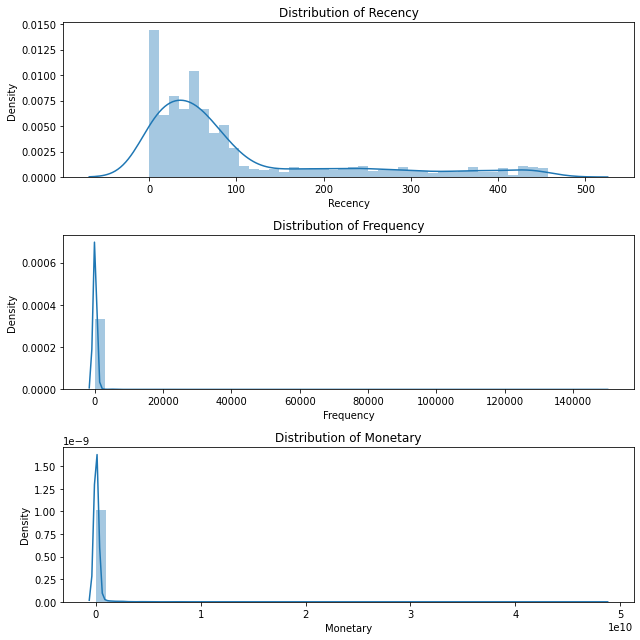

In [29]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary')

plt.tight_layout()

In [30]:
cols=['Recency','Frequency','Monetary']
df_rfm = RFM_Table[cols]

In [31]:
df_rfm

Recency  Frequency    Monetary
0           1       1829  2597177575
1         416         12    11152500
2           0      12518  5002966483
3          99        248  1026178550
4         167         61   114642100
...       ...        ...         ...
3655        0          1      535000
3656        0          1      535000
3657        0          2     2838500
3658        0          2     2868000
3659        0          2      887500

[3660 rows x 3 columns]

In [32]:
df_rfm = RFM_Table.copy()

In [33]:
df_rfm.head()

client_code  Recency  Frequency    Monetary
0  1.805211e+14        1       1829  2597177575
1  1.805211e+14      416         12    11152500
2  1.805220e+14        0      12518  5002966483
3  1.805221e+14       99        248  1026178550
4  1.805241e+14      167         61   114642100

In [34]:
windsoriser = Winsorizer(tail='both', # cap left, right or both tails 
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [35]:
df_rfm = windsoriser.transform(df_rfm)

In [36]:
scaler = StandardScaler()

scaler.fit(df_rfm)

RFM_Table_scaled = scaler.transform(df_rfm)

In [37]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)
RFM_Table_scaled.head()

NameError: name 'df_rfm_log' is not defined

In [39]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

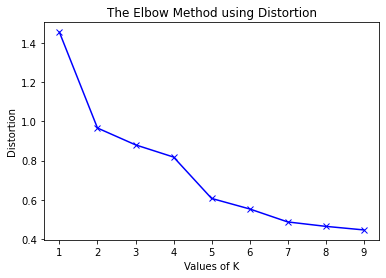

In [40]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

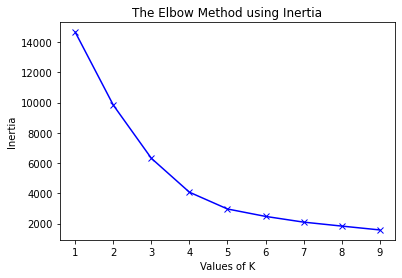

In [41]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [42]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

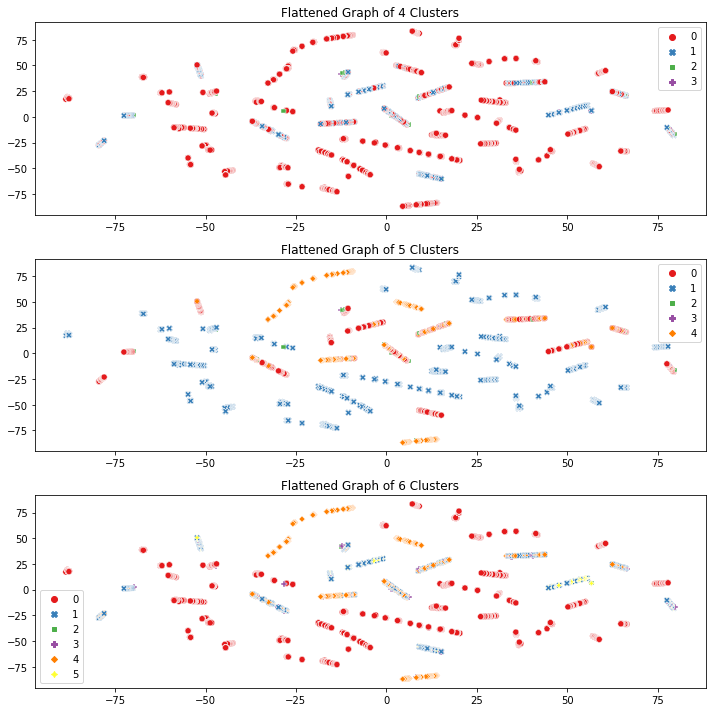

In [43]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k6 = kmeans(RFM_Table_scaled, 6, RFM_Table)

plt.tight_layout()


In [44]:

def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['client_code', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

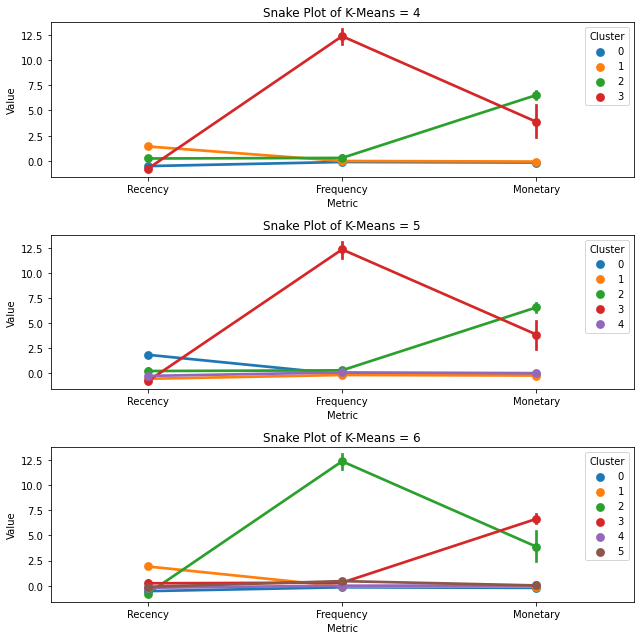

In [45]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 6')
snake_plot(RFM_Table_scaled, df_rfm_k6, RFM_Table)

plt.tight_layout()

In [46]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

In [47]:
df_rfm_k4['Monetary']=df_rfm_k4['Monetary'].astype(int)
rfm_values(df_rfm_k4)

Recency Frequency     Monetary      
           mean      mean         mean count
Cluster                                     
0          43.0      28.0   23974241.0  2648
1         267.0      69.0   50875578.0   934
2         128.0     198.0  330351831.0    58
3          15.0   19507.0  246603393.0    20

In [48]:
df_rfm_k5['Monetary']=df_rfm_k5['Monetary'].astype(int)
rfm_values(df_rfm_k5)

Recency Frequency     Monetary      
           mean      mean         mean count
Cluster                                     
0         318.0      40.0   42778257.0   693
1          40.0       4.0    7667450.0  1993
2         128.0     200.0  319088978.0    57
3          15.0   19507.0  246603393.0    20
4          70.0     113.0   74746216.0   897

In [49]:
df_rfm_k6['Monetary']=df_rfm_k6['Monetary'].astype(int)
rfm_values(df_rfm_k6)

Recency Frequency     Monetary      
           mean      mean         mean count
Cluster                                     
0          40.0       4.0    7667450.0  1993
1         326.0      38.0   42336118.0   647
2          15.0   19507.0  246603393.0    20
3         128.0     200.0  306462378.0    56
4          75.0      71.0   74369121.0   749
5          86.0     264.0   74999627.0   195